# **IP**

**XG Boost**

Training XGBoost model...
[0]	validation_0-mlogloss:2.35379	validation_1-mlogloss:2.38504
[1]	validation_0-mlogloss:2.07212	validation_1-mlogloss:2.12561
[2]	validation_0-mlogloss:1.86839	validation_1-mlogloss:1.93924


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:08:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:08:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-mlogloss:1.70608	validation_1-mlogloss:1.79167
[4]	validation_0-mlogloss:1.57252	validation_1-mlogloss:1.66968
[5]	validation_0-mlogloss:1.45888	validation_1-mlogloss:1.56664
[6]	validation_0-mlogloss:1.36082	validation_1-mlogloss:1.47734
[7]	validation_0-mlogloss:1.27382	validation_1-mlogloss:1.39831
[8]	validation_0-mlogloss:1.19646	validation_1-mlogloss:1.32888
[9]	validation_0-mlogloss:1.12770	validation_1-mlogloss:1.26687
[10]	validation_0-mlogloss:1.06560	validation_1-mlogloss:1.21167
[11]	validation_0-mlogloss:1.00997	validation_1-mlogloss:1.16225
[12]	validation_0-mlogloss:0.95825	validation_1-mlogloss:1.11674
[13]	validation_0-mlogloss:0.91167	validation_1-mlogloss:1.07598
[14]	validation_0-mlogloss:0.86883	validation_1-mlogloss:1.03834
[15]	validation_0-mlogloss:0.83088	validation_1-mlogloss:1.00533
[16]	validation_0-mlogloss:0.79422	validation_1-mlogloss:0.97378
[17]	validation_0-mlogloss:0.76224	validation_1-mlogloss:0.94604
[18]	validation_0-mlogloss:0.732

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:08:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


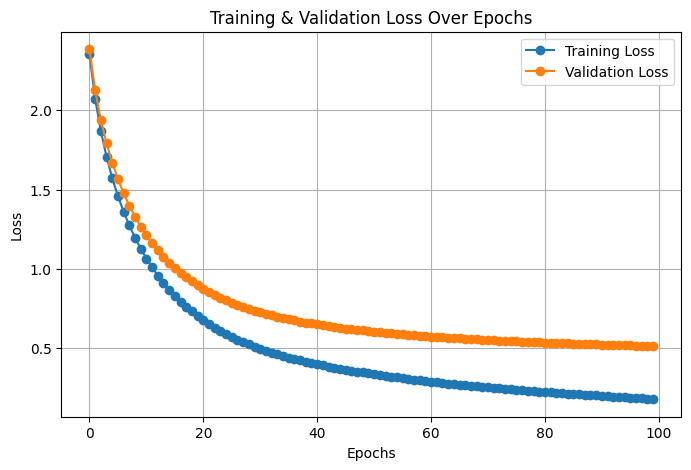

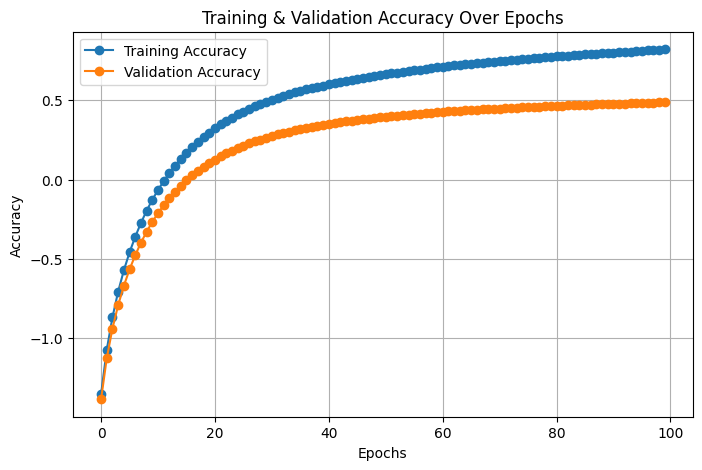

✅ Inference Time Per Sample: 20.94 ms


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc  # For memory usage tracking
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap

# --------------------------------------------
# ✅ Load Indian Pines Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train XGBoost Model (Tracking Time & Memory)
# --------------------------------------------
xgb_classifier = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # Number of classes
    eval_metric="mlogloss",
    use_label_encoder=False,
    tree_method="gpu_hist",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

print("Training XGBoost model...")

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

# End time and memory tracking
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
memory_usage_gb = peak / (1024 ** 2)  # Convert bytes to GB
tracemalloc.stop()

print(f"✅ Training Time: {training_time:.2f} seconds")
print(f"✅ Peak Memory Usage: {memory_usage_gb:.2f} MB")

# --------------------------------------------
# ✅ Extract Feature Embeddings from XGBoost
# --------------------------------------------
print("Extracting feature embeddings...")
X_train_embeddings = xgb_classifier.apply(X_train)  # Shape: [n_samples, n_trees]
X_test_embeddings = xgb_classifier.apply(X_test)    # Shape: [n_samples, n_trees]

# Use full dataset for visualization
features = np.vstack((X_train_embeddings, X_test_embeddings))
labels = np.concatenate((y_train, y_test))

# Define color palette
n_classes = len(np.unique(labels))
palette = sns.color_palette("bright", n_classes)

# --------------------------------------------
# ✅ Plot Training & Validation Loss Over Epochs
# --------------------------------------------
results = xgb_classifier.evals_result()
train_loss = results['validation_0']['mlogloss']
val_loss = results['validation_1']['mlogloss']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------
# ✅ Plot Training & Validation Accuracy Over Epochs
# --------------------------------------------
train_acc = [1 - loss for loss in train_loss]  # Approximate accuracy from loss
val_acc = [1 - loss for loss in val_loss]      # Approximate accuracy from loss

plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Training Accuracy", marker='o')
plt.plot(val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------
# ✅ Compute Inference Time Per Sample
# --------------------------------------------
sample = X_test[0].reshape(1, -1)  # Take a single test sample
start_time = time.time()
xgb_classifier.predict(sample)
inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

print(f"✅ Inference Time Per Sample: {inference_time:.2f} ms")

Computing t-SNE visualization...


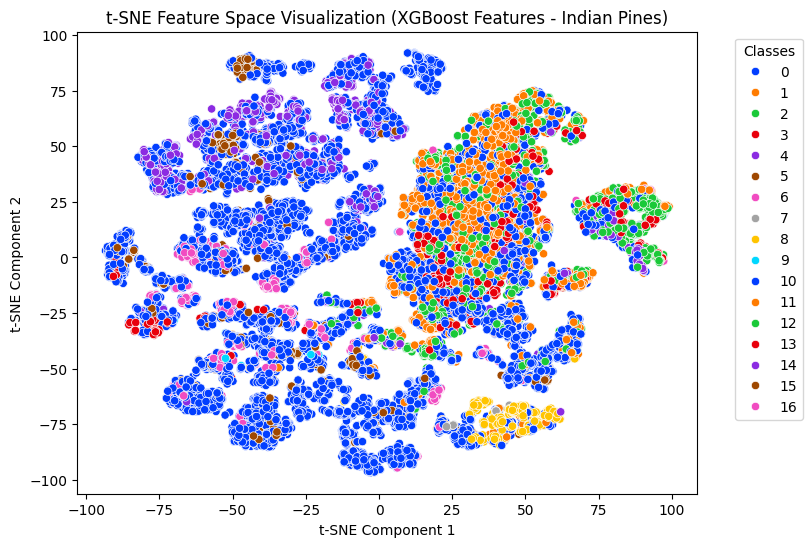

Computing UMAP visualization...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


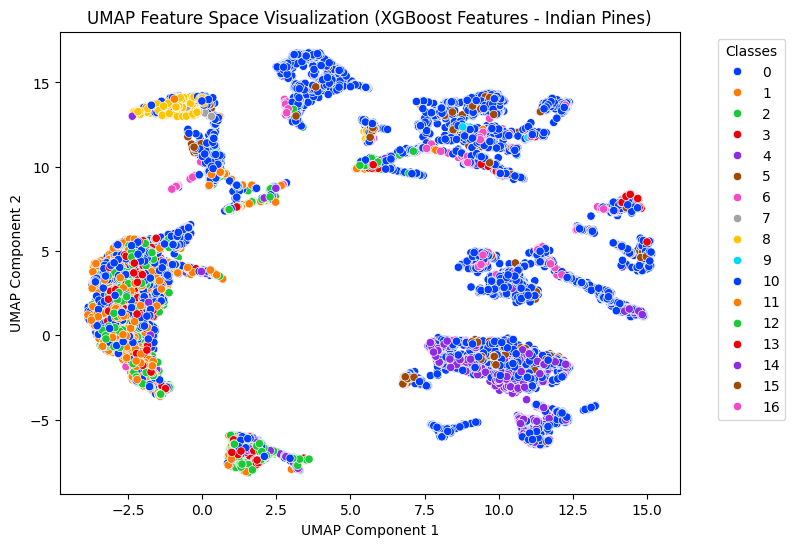

In [ ]:
# --------------------------------------------
# ✅ t-SNE Visualization (Legend Outside)
# --------------------------------------------
print("Computing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (XGBoost Features - Indian Pines)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# --------------------------------------------
# ✅ UMAP Visualization (Legend Outside)
# --------------------------------------------
print("Computing UMAP visualization...")
umap_embedder = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_embedder.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_umap[:, 0], y=features_umap[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (XGBoost Features - Indian Pines)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

**ADA Boost**

Training AdaBoost model...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


✅ Training Time: 77.66 seconds
✅ Peak Memory Usage: 15.54 MB
Extracting feature embeddings...
✅ Inference Time Per Sample: 16.92 ms
Computing t-SNE visualization...


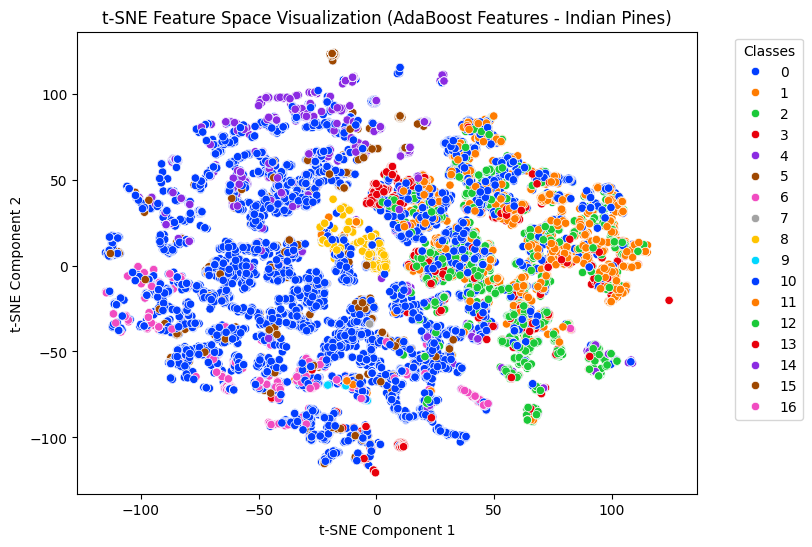

Computing UMAP visualization...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


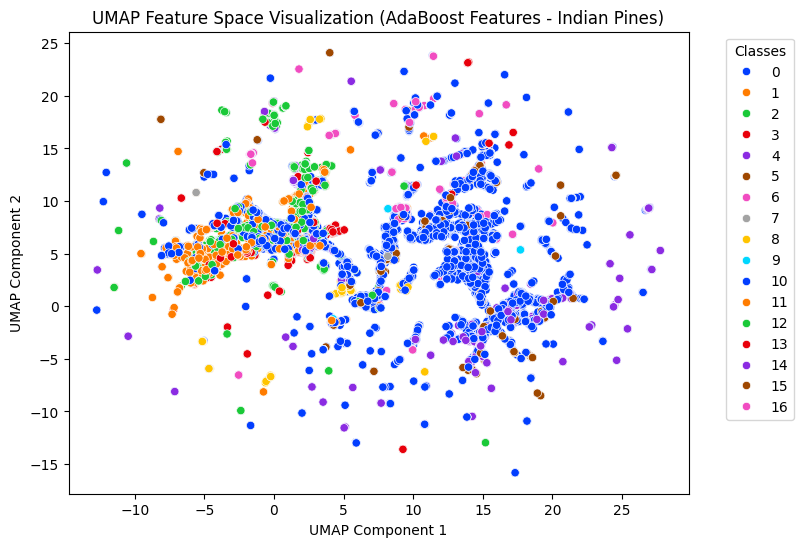

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc  # For memory usage tracking
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap

# --------------------------------------------
# ✅ Load Indian Pines Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train AdaBoost Model (Tracking Time & Memory)
# --------------------------------------------
ada_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Weak learner
    n_estimators=100,  # Number of weak classifiers
    learning_rate=0.1,
    algorithm="SAMME"  # Suitable for multi-class classification
)

print("Training AdaBoost model...")

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

ada_classifier.fit(X_train, y_train)

# End time and memory tracking
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
memory_usage_gb = peak / (1024 ** 2)  # Convert bytes to GB
tracemalloc.stop()

print(f"✅ Training Time: {training_time:.2f} seconds")
print(f"✅ Peak Memory Usage: {memory_usage_gb:.2f} MB")

# --------------------------------------------
# ✅ Extract Feature Embeddings from AdaBoost using predicted probabilities
# --------------------------------------------
print("Extracting feature embeddings...")

# Use predicted class probabilities as embeddings
X_train_embeddings = ada_classifier.predict_proba(X_train)  # Predicted probabilities for train
X_test_embeddings = ada_classifier.predict_proba(X_test)    # Predicted probabilities for test

# Use full dataset for visualization
features = np.vstack((X_train_embeddings, X_test_embeddings))
labels = np.concatenate((y_train, y_test))

# Define color palette
n_classes = len(np.unique(labels))
palette = sns.color_palette("bright", n_classes)

# --------------------------------------------
# ✅ Compute Inference Time Per Sample
# --------------------------------------------
sample = X_test[0].reshape(1, -1)  # Take a single test sample
start_time = time.time()
ada_classifier.predict(sample)
inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

print(f"✅ Inference Time Per Sample: {inference_time:.2f} ms")

# --------------------------------------------
# ✅ t-SNE Visualization (Legend Outside)
# --------------------------------------------
print("Computing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (AdaBoost Features - Indian Pines)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# --------------------------------------------
# ✅ UMAP Visualization (Legend Outside)
# --------------------------------------------
print("Computing UMAP visualization...")
umap_embedder = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_embedder.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_umap[:, 0], y=features_umap[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (AdaBoost Features - Indian Pines)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

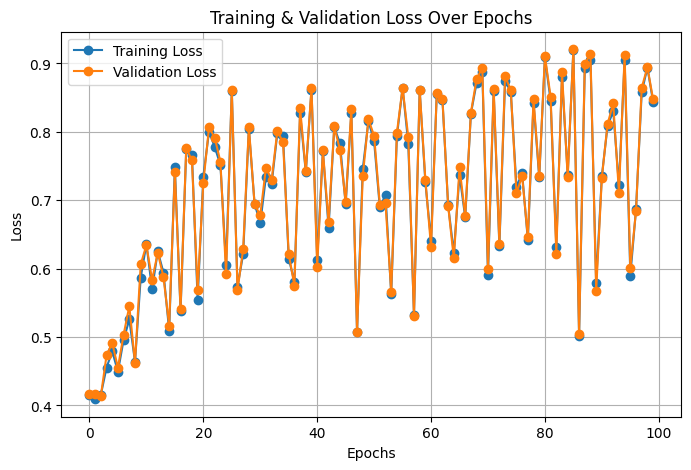

In [ ]:
# --------------------------------------------
# ✅ Track Training & Validation Loss
# --------------------------------------------
train_loss = []
val_loss = []

for estimator in ada_classifier.estimators_:
    # Training Loss (1 - Accuracy)
    y_train_pred = estimator.predict(X_train)
    train_loss.append(1 - accuracy_score(y_train, y_train_pred))

    # Validation Loss (1 - Accuracy)
    y_val_pred = estimator.predict(X_test)
    val_loss.append(1 - accuracy_score(y_test, y_val_pred))

# --------------------------------------------
# ✅ Plot Training & Validation Loss Over Iterations
# --------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", marker='o', linestyle='-')
plt.plot(val_loss, label="Validation Loss", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

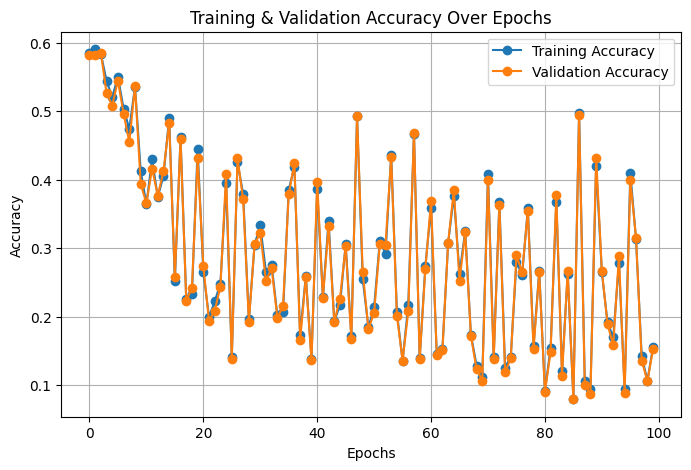

In [ ]:
from sklearn.metrics import accuracy_score

# --------------------------------------------
# ✅ Track Training & Validation Accuracy
# --------------------------------------------
train_acc = []
val_acc = []

for estimator in ada_classifier.estimators_:
    # Training Accuracy
    y_train_pred = estimator.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_train_pred))

    # Validation Accuracy
    y_val_pred = estimator.predict(X_test)
    val_acc.append(accuracy_score(y_test, y_val_pred))

# --------------------------------------------
# ✅ Plot Training & Validation Accuracy Over Iterations
# --------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Training Accuracy", marker='o', linestyle='-')
plt.plot(val_acc, label="Validation Accuracy", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

**CatBoost**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y numpy catboost
!pip install numpy catboost --upgrade

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc  # For memory usage tracking
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap

# --------------------------------------------
# ✅ Load Indian Pines Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train CatBoost Model (Tracking Time & Memory)
# --------------------------------------------
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    task_type="GPU",
    verbose=50
)

print("Training CatBoost model...")

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

catboost_classifier.fit(X_train, y_train)

# End time and memory tracking
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
memory_usage_gb = peak / (1024 ** 2)  # Convert bytes to GB
tracemalloc.stop()

print(f"✅ Training Time: {training_time:.2f} seconds")
print(f"✅ Peak Memory Usage: {memory_usage_gb:.2f} MB")


Training CatBoost model...
0:	learn: 2.2220088	total: 13.8ms	remaining: 13.8s
50:	learn: 0.8367108	total: 713ms	remaining: 13.3s
100:	learn: 0.7054698	total: 1.42s	remaining: 12.7s
150:	learn: 0.6279998	total: 2.14s	remaining: 12s
200:	learn: 0.5726934	total: 2.85s	remaining: 11.3s
250:	learn: 0.5297150	total: 3.56s	remaining: 10.6s
300:	learn: 0.4948440	total: 4.26s	remaining: 9.91s
350:	learn: 0.4644329	total: 4.97s	remaining: 9.19s
400:	learn: 0.4384006	total: 5.68s	remaining: 8.48s
450:	learn: 0.4154143	total: 6.38s	remaining: 7.76s
500:	learn: 0.3951337	total: 7.08s	remaining: 7.05s
550:	learn: 0.3739628	total: 7.79s	remaining: 6.35s
600:	learn: 0.3566610	total: 8.5s	remaining: 5.64s
650:	learn: 0.3404487	total: 9.2s	remaining: 4.93s
700:	learn: 0.3256420	total: 9.9s	remaining: 4.22s
750:	learn: 0.3117100	total: 10.6s	remaining: 3.51s
800:	learn: 0.2987862	total: 11.3s	remaining: 2.81s
850:	learn: 0.2857439	total: 12s	remaining: 2.1s
900:	learn: 0.2731399	total: 12.7s	remaining: 1

Extracting feature embeddings...
0:	learn: 2.2220078	test: 2.2273846	best: 2.2273846 (0)	total: 15ms	remaining: 15s
50:	learn: 0.8367107	test: 0.8795439	best: 0.8795439 (50)	total: 721ms	remaining: 13.4s
100:	learn: 0.7054698	test: 0.7732100	best: 0.7732100 (100)	total: 1.44s	remaining: 12.8s
150:	learn: 0.6279998	test: 0.7154564	best: 0.7154564 (150)	total: 2.16s	remaining: 12.1s
200:	learn: 0.5726933	test: 0.6767317	best: 0.6767317 (200)	total: 2.87s	remaining: 11.4s
250:	learn: 0.5297150	test: 0.6495700	best: 0.6495700 (250)	total: 3.58s	remaining: 10.7s
300:	learn: 0.4948439	test: 0.6273876	best: 0.6273876 (300)	total: 4.3s	remaining: 10s
350:	learn: 0.4644329	test: 0.6098365	best: 0.6098365 (350)	total: 5.02s	remaining: 9.28s
400:	learn: 0.4384006	test: 0.5951907	best: 0.5951907 (400)	total: 5.72s	remaining: 8.54s
450:	learn: 0.4154143	test: 0.5824810	best: 0.5824637 (449)	total: 6.43s	remaining: 7.82s
500:	learn: 0.3951337	test: 0.5717651	best: 0.5717651 (500)	total: 7.14s	remain

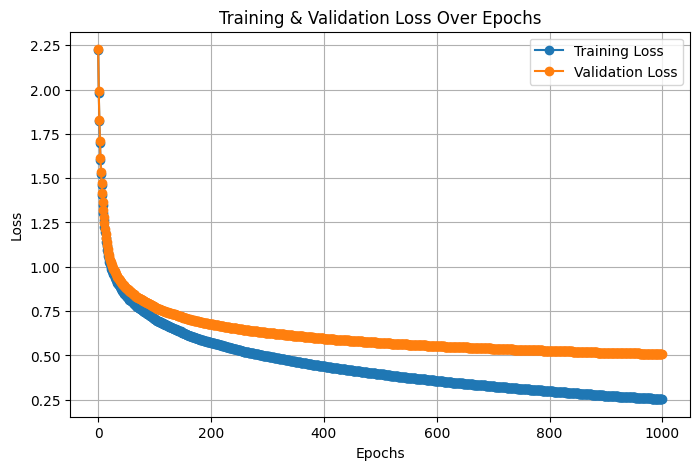

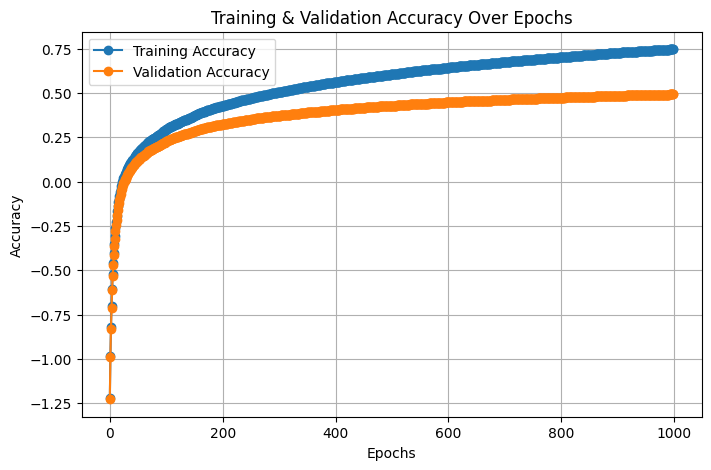

✅ Inference Time Per Sample: 4.97 ms
Computing t-SNE visualization...


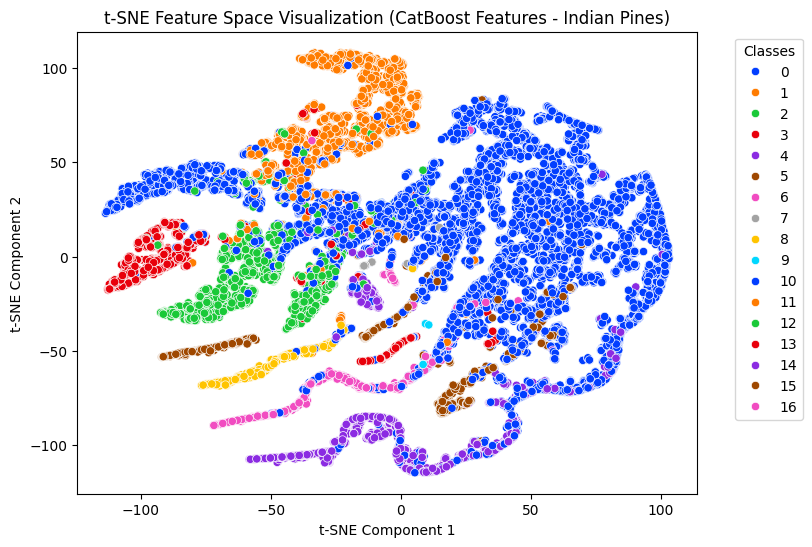

Computing UMAP visualization...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


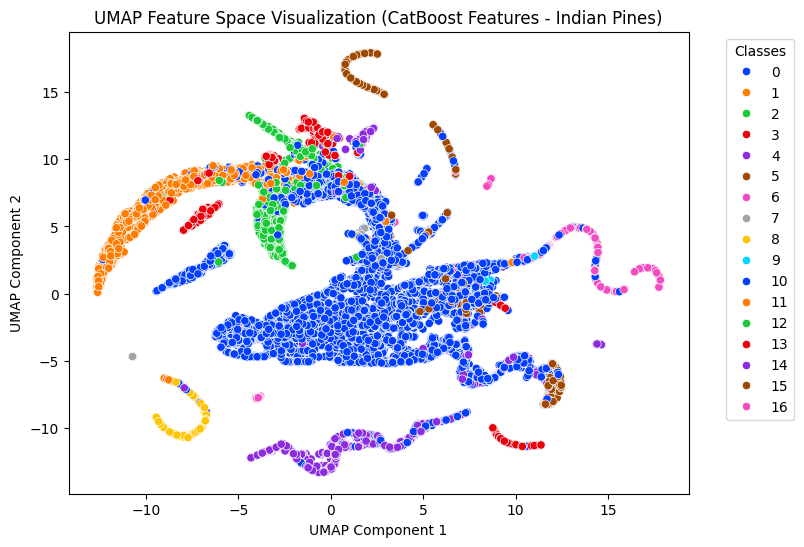

In [ ]:
# --------------------------------------------
# ✅ Extract Feature Embeddings from CatBoost
# --------------------------------------------
print("Extracting feature embeddings...")
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors from CatBoost
X_test_embeddings = catboost_classifier.predict_proba(X_test)

# Use full dataset for visualization
features = np.vstack((X_train_embeddings, X_test_embeddings))
labels = np.concatenate((y_train, y_test))

# Define color palette
n_classes = len(np.unique(labels))
palette = sns.color_palette("bright", n_classes)

# Fit the model while tracking validation loss
catboost_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # Validation set
    use_best_model=True,
    plot=False  # Avoid direct plotting by CatBoost
)

# Extract training and validation loss
train_loss = catboost_classifier.get_evals_result()['learn']['MultiClass']
val_loss = catboost_classifier.get_evals_result()['validation']['MultiClass']

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Extract accuracy (1 - loss for classification tasks)
train_acc = 1 - np.array(train_loss)
val_acc = 1 - np.array(val_loss)

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Training Accuracy", marker='o')
plt.plot(val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------
# ✅ Compute Inference Time Per Sample
# --------------------------------------------
sample = X_test[0].reshape(1, -1)  # Take a single test sample
start_time = time.time()
catboost_classifier.predict(sample)
inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

print(f"✅ Inference Time Per Sample: {inference_time:.2f} ms")

# --------------------------------------------
# ✅ t-SNE Visualization (Legend Outside)
# --------------------------------------------
print("Computing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (CatBoost Features - Indian Pines)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# --------------------------------------------
# ✅ UMAP Visualization (Legend Outside)
# --------------------------------------------
print("Computing UMAP visualization...")
umap_embedder = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_embedder.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_umap[:, 0], y=features_umap[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (CatBoost Features - Indian Pines)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

# **SALINAS**

**XG Boost**

Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.21068	validation_1-mlogloss:2.22870
[1]	validation_0-mlogloss:1.88619	validation_1-mlogloss:1.91503
[2]	validation_0-mlogloss:1.65682	validation_1-mlogloss:1.69296
[3]	validation_0-mlogloss:1.48046	validation_1-mlogloss:1.52256
[4]	validation_0-mlogloss:1.33725	validation_1-mlogloss:1.38458
[5]	validation_0-mlogloss:1.21753	validation_1-mlogloss:1.26918
[6]	validation_0-mlogloss:1.11476	validation_1-mlogloss:1.17027
[7]	validation_0-mlogloss:1.02577	validation_1-mlogloss:1.08479
[8]	validation_0-mlogloss:0.94708	validation_1-mlogloss:1.00951
[9]	validation_0-mlogloss:0.87726	validation_1-mlogloss:0.94269
[10]	validation_0-mlogloss:0.81465	validation_1-mlogloss:0.88319
[11]	validation_0-mlogloss:0.75929	validation_1-mlogloss:0.83059
[12]	validation_0-mlogloss:0.70936	validation_1-mlogloss:0.78293
[13]	validation_0-mlogloss:0.66505	validation_1-mlogloss:0.74090
[14]	validation_0-mlogloss:0.62449	validation_1-mlogloss:0.70251
[15]	validation_0-mlogloss:0.58776	

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


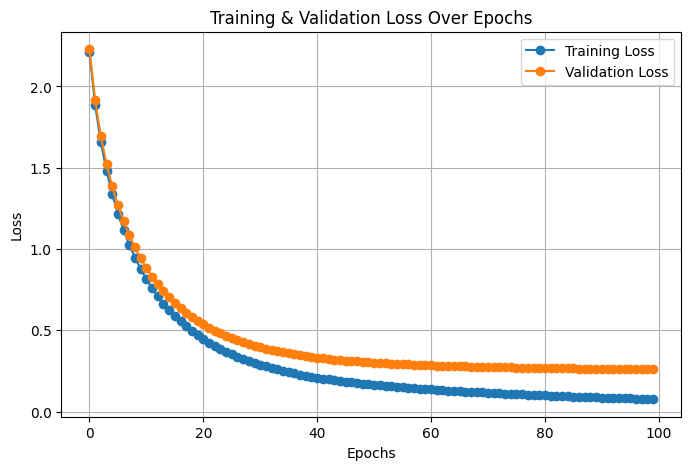

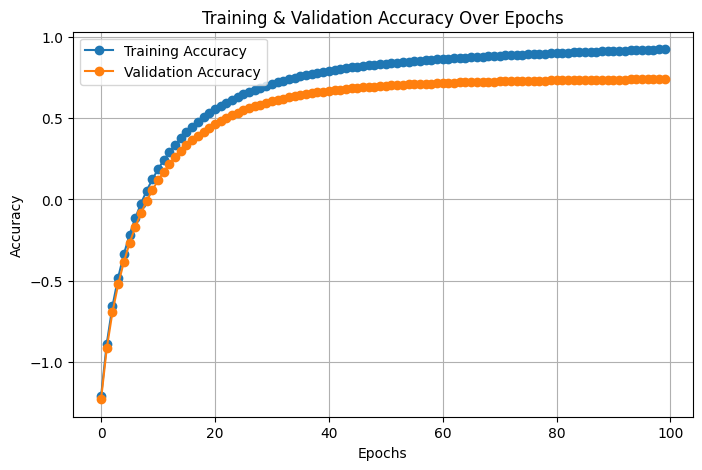

✅ Inference Time Per Sample: 20.43 ms


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:03:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc  # For memory usage tracking
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap

# --------------------------------------------
# ✅ Load Salinas Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train XGBoost Model (Tracking Time & Memory)
# --------------------------------------------
xgb_classifier = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # Number of classes
    eval_metric="mlogloss",
    use_label_encoder=False,
    tree_method="gpu_hist",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1
)

print("Training XGBoost model...")

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

# End time and memory tracking
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
memory_usage_gb = peak / (1024 ** 2)  # Convert bytes to GB
tracemalloc.stop()

print(f"✅ Training Time: {training_time:.2f} seconds")
print(f"✅ Peak Memory Usage: {memory_usage_gb:.2f} MB")

# --------------------------------------------
# ✅ Extract Feature Embeddings from XGBoost
# --------------------------------------------
print("Extracting feature embeddings...")
X_train_embeddings = xgb_classifier.apply(X_train)  # Shape: [n_samples, n_trees]
X_test_embeddings = xgb_classifier.apply(X_test)    # Shape: [n_samples, n_trees]

# Use full dataset for visualization
features = np.vstack((X_train_embeddings, X_test_embeddings))
labels = np.concatenate((y_train, y_test))

# Define color palette
n_classes = len(np.unique(labels))
palette = sns.color_palette("bright", n_classes)

# --------------------------------------------
# ✅ Plot Training & Validation Loss Over Epochs
# --------------------------------------------
results = xgb_classifier.evals_result()
train_loss = results['validation_0']['mlogloss']
val_loss = results['validation_1']['mlogloss']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------
# ✅ Plot Training & Validation Accuracy Over Epochs
# --------------------------------------------
train_acc = [1 - loss for loss in train_loss]  # Approximate accuracy from loss
val_acc = [1 - loss for loss in val_loss]      # Approximate accuracy from loss

plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Training Accuracy", marker='o')
plt.plot(val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------
# ✅ Compute Inference Time Per Sample
# --------------------------------------------
sample = X_test[0].reshape(1, -1)  # Take a single test sample
start_time = time.time()
xgb_classifier.predict(sample)
inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

print(f"✅ Inference Time Per Sample: {inference_time:.2f} ms")

Computing t-SNE visualization...


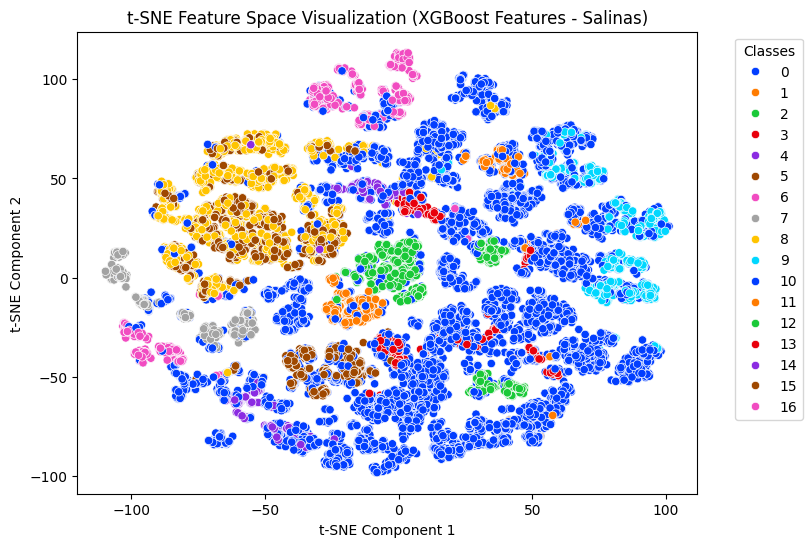

Computing UMAP visualization...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


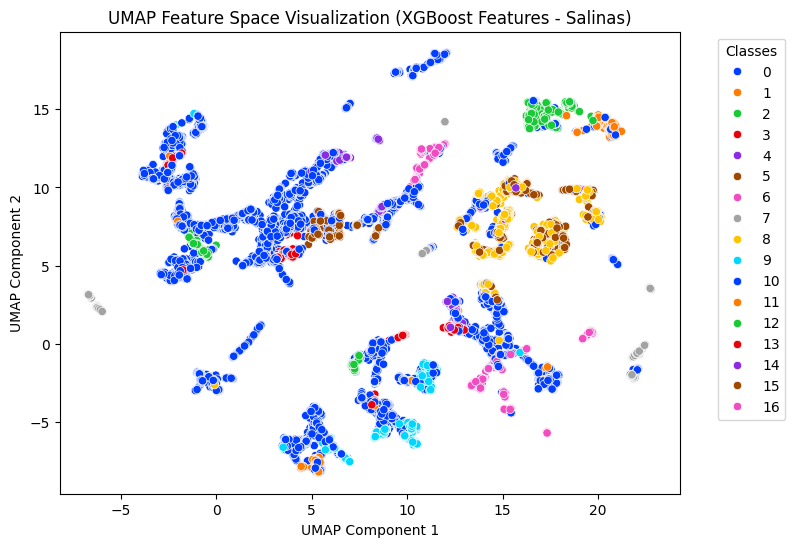

In [ ]:
# --------------------------------------------
# ✅ t-SNE Visualization (Legend Outside)
# --------------------------------------------
print("Computing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (XGBoost Features - Salinas)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# --------------------------------------------
# ✅ UMAP Visualization (Legend Outside)
# --------------------------------------------
print("Computing UMAP visualization...")
umap_embedder = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_embedder.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_umap[:, 0], y=features_umap[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (XGBoost Features - Salinas)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

**ADA Boost**

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc  # For memory usage tracking
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap

# --------------------------------------------
# ✅ Load Salinas Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train AdaBoost Model (Tracking Time & Memory)
# --------------------------------------------
ada_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),  # Weak learner
    n_estimators=100,  # Number of weak classifiers
    learning_rate=0.1,
    algorithm="SAMME"  # Suitable for multi-class classification
)

print("Training AdaBoost model...")

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

ada_classifier.fit(X_train, y_train)

# End time and memory tracking
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
memory_usage_gb = peak / (1024 ** 2)  # Convert bytes to GB
tracemalloc.stop()

print(f"✅ Training Time: {training_time:.2f} seconds")
print(f"✅ Peak Memory Usage: {memory_usage_gb:.2f} MB")



Training AdaBoost model...


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


✅ Training Time: 74.77 seconds
✅ Peak Memory Usage: 17.18 MB


Extracting feature embeddings...


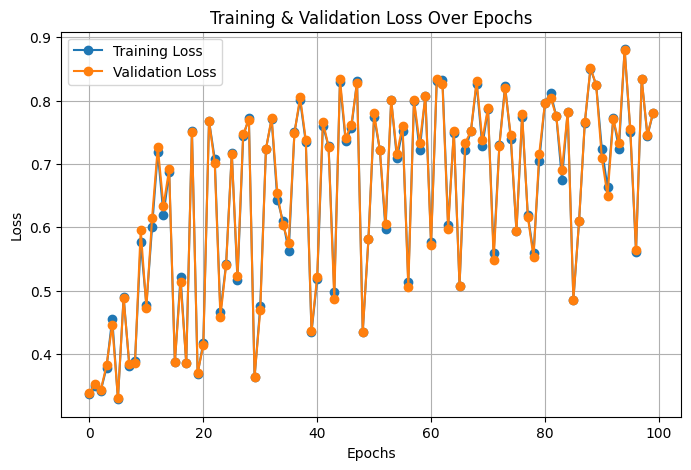

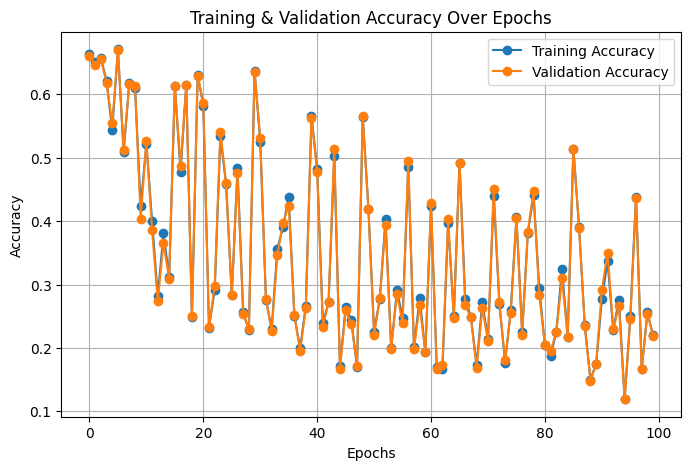

✅ Inference Time Per Sample: 22.34 ms
Computing t-SNE visualization...


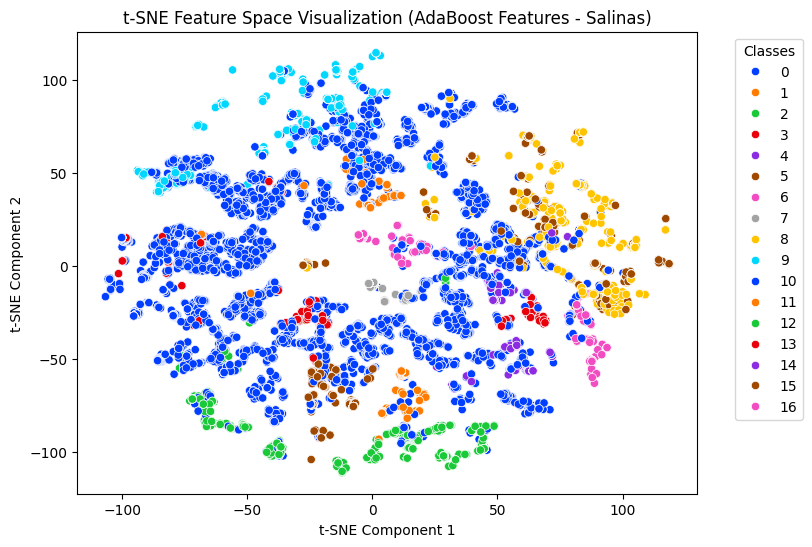

Computing UMAP visualization...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


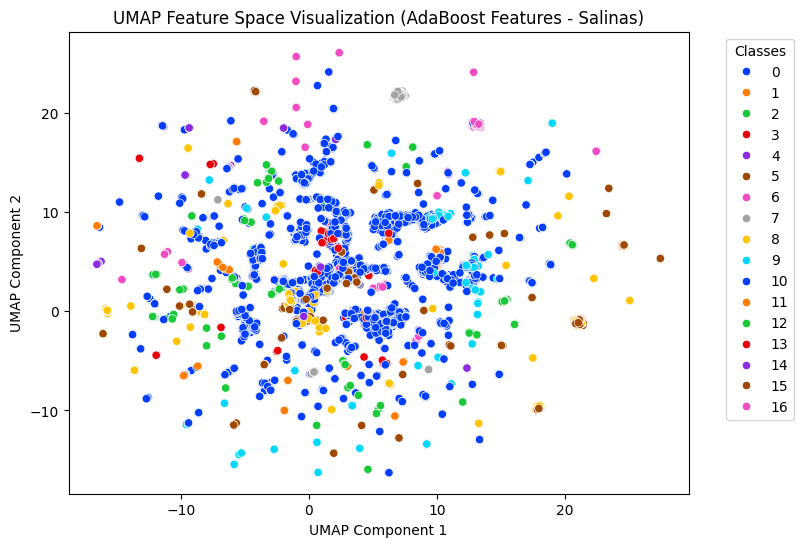

In [ ]:
from sklearn.metrics import accuracy_score
# --------------------------------------------
# ✅ Extract Feature Embeddings from AdaBoost using predicted probabilities
# --------------------------------------------
print("Extracting feature embeddings...")

# Use predicted class probabilities as embeddings
X_train_embeddings = ada_classifier.predict_proba(X_train)  # Predicted probabilities for train
X_test_embeddings = ada_classifier.predict_proba(X_test)    # Predicted probabilities for test

# Use full dataset for visualization
features = np.vstack((X_train_embeddings, X_test_embeddings))
labels = np.concatenate((y_train, y_test))

# Define color palette
n_classes = len(np.unique(labels))
palette = sns.color_palette("bright", n_classes)

# --------------------------------------------
# ✅ Track Training & Validation Loss
# --------------------------------------------
train_loss = []
val_loss = []

for estimator in ada_classifier.estimators_:
    # Training Loss (1 - Accuracy)
    y_train_pred = estimator.predict(X_train)
    train_loss.append(1 - accuracy_score(y_train, y_train_pred))

    # Validation Loss (1 - Accuracy)
    y_val_pred = estimator.predict(X_test)
    val_loss.append(1 - accuracy_score(y_test, y_val_pred))

# --------------------------------------------
# ✅ Plot Training & Validation Loss Over Iterations
# --------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", marker='o', linestyle='-')
plt.plot(val_loss, label="Validation Loss", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
from sklearn.metrics import accuracy_score

# --------------------------------------------
# ✅ Track Training & Validation Accuracy
# --------------------------------------------
train_acc = []
val_acc = []

for estimator in ada_classifier.estimators_:
    # Training Accuracy
    y_train_pred = estimator.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_train_pred))

    # Validation Accuracy
    y_val_pred = estimator.predict(X_test)
    val_acc.append(accuracy_score(y_test, y_val_pred))

# --------------------------------------------
# ✅ Plot Training & Validation Accuracy Over Iterations
# --------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Training Accuracy", marker='o', linestyle='-')
plt.plot(val_acc, label="Validation Accuracy", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------
# ✅ Compute Inference Time Per Sample
# --------------------------------------------
sample = X_test[0].reshape(1, -1)  # Take a single test sample
start_time = time.time()
ada_classifier.predict(sample)
inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

print(f"✅ Inference Time Per Sample: {inference_time:.2f} ms")

# --------------------------------------------
# ✅ t-SNE Visualization (Legend Outside)
# --------------------------------------------
print("Computing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (AdaBoost Features - Salinas)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# --------------------------------------------
# ✅ UMAP Visualization (Legend Outside)
# --------------------------------------------
print("Computing UMAP visualization...")
umap_embedder = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_embedder.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_umap[:, 0], y=features_umap[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (AdaBoost Features - Salinas)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

**Cat Boost**

In [ ]:
!pip install catboost

In [ ]:
!pip uninstall -y numpy catboost
!pip install numpy catboost --upgrade

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tracemalloc  # For memory usage tracking
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap.umap_ as umap

# --------------------------------------------
# ✅ Load Salinas Dataset
# --------------------------------------------
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)

ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -4].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data for Training and Testing (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --------------------------------------------
# ✅ Train CatBoost Model (Tracking Time & Memory)
# --------------------------------------------
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    task_type="GPU",
    verbose=50
)

print("Training CatBoost model...")

# Start tracking time and memory
tracemalloc.start()
start_time = time.time()

catboost_classifier.fit(X_train, y_train)

# End time and memory tracking
training_time = time.time() - start_time
current, peak = tracemalloc.get_traced_memory()
memory_usage_gb = peak / (1024 ** 2)  # Convert bytes to GB
tracemalloc.stop()

print(f"✅ Training Time: {training_time:.2f} seconds")
print(f"✅ Peak Memory Usage: {memory_usage_gb:.2f} MB")

Training CatBoost model...
0:	learn: 2.0383114	total: 14.7ms	remaining: 14.7s
50:	learn: 0.4245617	total: 722ms	remaining: 13.4s
100:	learn: 0.3474875	total: 1.45s	remaining: 12.9s
150:	learn: 0.3078338	total: 2.17s	remaining: 12.2s
200:	learn: 0.2787361	total: 2.9s	remaining: 11.5s
250:	learn: 0.2586064	total: 3.62s	remaining: 10.8s
300:	learn: 0.2430352	total: 4.33s	remaining: 10.1s
350:	learn: 0.2279850	total: 5.05s	remaining: 9.34s
400:	learn: 0.2157942	total: 5.77s	remaining: 8.62s
450:	learn: 0.2037743	total: 6.48s	remaining: 7.89s
500:	learn: 0.1926324	total: 7.2s	remaining: 7.17s
550:	learn: 0.1838308	total: 7.91s	remaining: 6.45s
600:	learn: 0.1751721	total: 8.62s	remaining: 5.72s
650:	learn: 0.1680752	total: 9.33s	remaining: 5s
700:	learn: 0.1608283	total: 10s	remaining: 4.28s
750:	learn: 0.1544673	total: 10.7s	remaining: 3.56s
800:	learn: 0.1483800	total: 11.4s	remaining: 2.84s
850:	learn: 0.1428728	total: 12.1s	remaining: 2.13s
900:	learn: 0.1377606	total: 12.8s	remaining: 

Extracting feature embeddings...
0:	learn: 2.0383109	test: 2.0438917	best: 2.0438917 (0)	total: 14.6ms	remaining: 14.6s
10:	learn: 0.8848645	test: 0.8987616	best: 0.8987616 (10)	total: 154ms	remaining: 13.8s
20:	learn: 0.6233245	test: 0.6373777	best: 0.6373777 (20)	total: 299ms	remaining: 13.9s
30:	learn: 0.5209366	test: 0.5367773	best: 0.5367773 (30)	total: 446ms	remaining: 13.9s
40:	learn: 0.4663201	test: 0.4851670	best: 0.4851670 (40)	total: 588ms	remaining: 13.8s
50:	learn: 0.4245617	test: 0.4457711	best: 0.4457711 (50)	total: 734ms	remaining: 13.7s
60:	learn: 0.3999930	test: 0.4235011	best: 0.4235011 (60)	total: 883ms	remaining: 13.6s
70:	learn: 0.3812605	test: 0.4071095	best: 0.4071095 (70)	total: 1.03s	remaining: 13.5s
80:	learn: 0.3690554	test: 0.3963329	best: 0.3963329 (80)	total: 1.17s	remaining: 13.3s
90:	learn: 0.3582779	test: 0.3871791	best: 0.3871791 (90)	total: 1.32s	remaining: 13.2s
100:	learn: 0.3474875	test: 0.3791479	best: 0.3791479 (100)	total: 1.46s	remaining: 13s


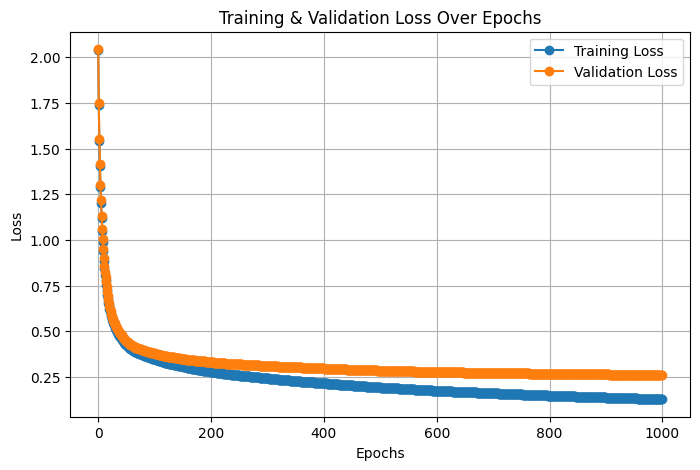

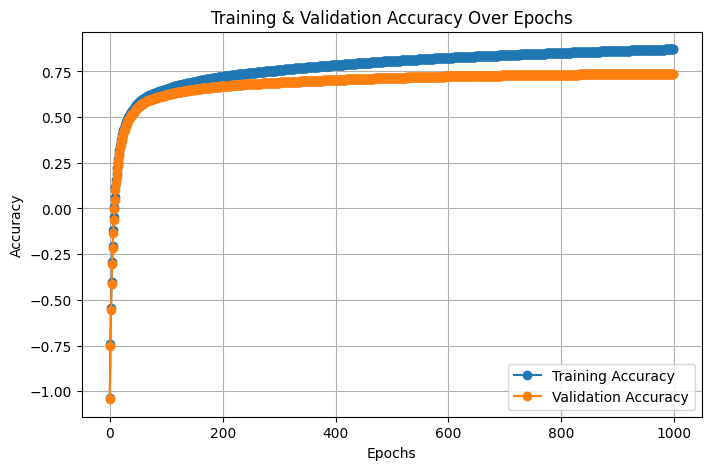

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d05741c2a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


✅ Inference Time Per Sample: 3.90 ms
Computing t-SNE visualization...


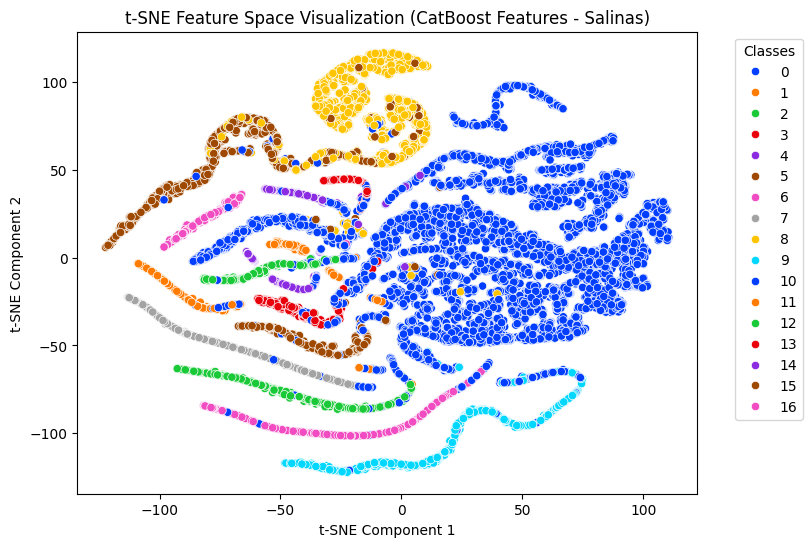

Computing UMAP visualization...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


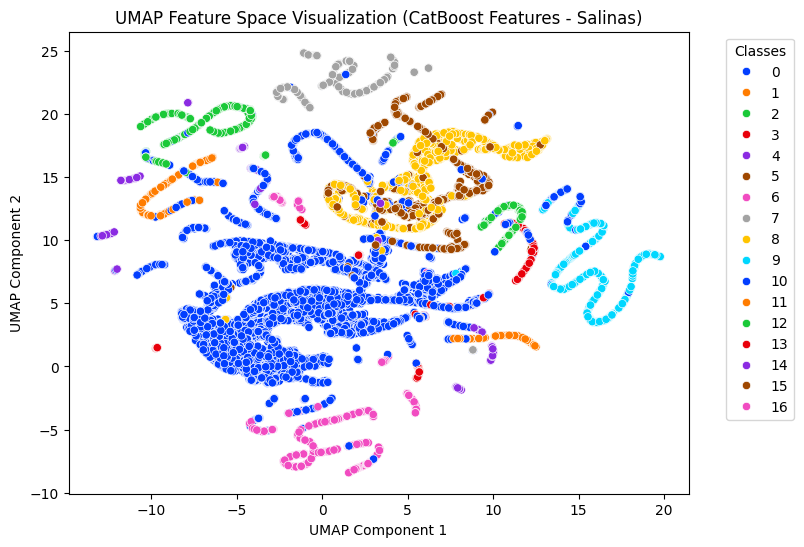

In [ ]:
# --------------------------------------------
# ✅ Extract Feature Embeddings from CatBoost
# --------------------------------------------
print("Extracting feature embeddings...")
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors from CatBoost
X_test_embeddings = catboost_classifier.predict_proba(X_test)

# Use full dataset for visualization
features = np.vstack((X_train_embeddings, X_test_embeddings))
labels = np.concatenate((y_train, y_test))

# Define color palette
n_classes = len(np.unique(labels))
palette = sns.color_palette("bright", n_classes)

# Fit the model while tracking validation loss
catboost_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # Validation set
    use_best_model=True,
    plot=False  # Avoid direct plotting by CatBoost
)

# Extract training and validation loss
train_loss = catboost_classifier.get_evals_result()['learn']['MultiClass']
val_loss = catboost_classifier.get_evals_result()['validation']['MultiClass']

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Extract accuracy (1 - loss for classification tasks)
train_acc = 1 - np.array(train_loss)
val_acc = 1 - np.array(val_loss)

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Training Accuracy", marker='o')
plt.plot(val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------
# ✅ Compute Inference Time Per Sample
# --------------------------------------------
sample = X_test[0].reshape(1, -1)  # Take a single test sample
start_time = time.time()
catboost_classifier.predict(sample)
inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

print(f"✅ Inference Time Per Sample: {inference_time:.2f} ms")

# --------------------------------------------
# ✅ t-SNE Visualization (Legend Outside)
# --------------------------------------------
print("Computing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (CatBoost Features - Salinas)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# --------------------------------------------
# ✅ UMAP Visualization (Legend Outside)
# --------------------------------------------
print("Computing UMAP visualization...")
umap_embedder = umap.UMAP(n_components=2, random_state=42)
features_umap = umap_embedder.fit_transform(features)

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_umap[:, 0], y=features_umap[:, 1], hue=labels,
                     palette=palette, legend="full")

# Move legend outside
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (CatBoost Features - Salinas)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()